In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('user.csv')
# 删除文本属性
for col in ['所在地', '自我介绍', '标签', '昵称']:
    data = data.drop(col, 1)

# 删除对伴侣要求的数据
for col in data.columns:
    if '要求' in col:
        data = data.drop(col, 1)
        
# 删除缺失值过多的属性
for col in data.columns:
    if sum(data[col].isnull())/data.shape[0] > 0.1:
        data = data.drop(col, 1)
data.head()

,userID,年龄,所在省,creditedNum,文凭,性别,身高,学历认证,身份认证,手机认证,...,恋爱类型,所在地区,星座,是否吸烟,是否喝酒,是否想要小孩,月薪,有无子女,民族,职业
0,56013059,34,河南,1,本科,男,177,0,0,1,...,公务员型,河南省,魔羯座,不吸烟，但不反感,不喝酒,NaN,2000-5000,没有,汉族,其它
1,50027250,48,江苏,1,本科,男,171,0,0,1,...,照顾者型,江苏省,双鱼座,社交时偶尔吸烟,兴致时小酌,想,10000-20000,没有,汉族,高级经营管理
2,55748374,34,河南,1,本科,男,170,0,0,1,...,主人型,河南省,白羊座,不吸烟，但不反感,不喝酒,想,5000-10000,没有,汉族,其它
3,50030782,42,江苏,0,本科,男,174,0,0,0,...,艺术家型,江苏省,天蝎座,烟不离手,兴致时小酌,还没想好,5000-10000,没有,汉族,高级经营管理
4,53824654,35,河北,2,本科,男,178,0,1,1,...,发明家型,河北省,金牛座,不吸烟，但不反感,不喝酒,想,2000-5000,没有,汉族,高级经营管理


In [2]:
data_id = ['userID']
categorical = ['所在省', '文凭', '性别', '学历认证', '身份认证', '手机认证', '芝麻信用认证', '身份通认证', '照片', '本人婚姻状况', 
               '宗教信仰', '属相', '恋爱类型', '星座', '是否吸烟', '是否喝酒', '是否想要小孩', '有无子女', '民族', '职业', '月薪']
numerical = ['年龄', 'creditedNum', '身高']

cate_data = data[categorical]
numerical_data = data[numerical]

In [3]:
cate_data = cate_data.fillna('missing')
cate_data = pd.get_dummies(cate_data)

In [4]:
for col in numerical_data.columns:
    numerical_data[col] = numerical_data[col].fillna(numerical_data[col].mean())
x = pd.concat([cate_data, numerical_data], axis=1)
x.head()

D:\softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,学历认证,身份认证,手机认证,芝麻信用认证,身份通认证,所在省_missing,所在省_上海,所在省_云南,所在省_内蒙古,所在省_北京,...,月薪_2000-5000,月薪_20000-50000,月薪_2000以下,月薪_5000-10000,月薪_>50000,月薪_missing,月薪_水晶及以上级别可见,年龄,creditedNum,身高
0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,34,1,177
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,48,1,171
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,34,1,170
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,42,0,174
4,0,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,35,2,178


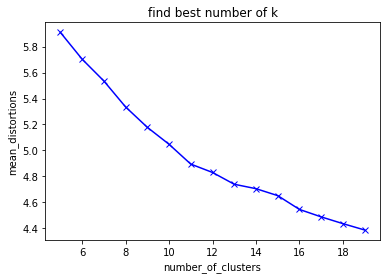

In [6]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

K = range(5, 20)
mean_distortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    mean_distortions.append(sum(np.min(cdist(x,kmeans.cluster_centers_, 'euclidean'), axis=1))/x.shape[0])
    
plt.plot(K, mean_distortions, 'bx-')
plt.xlabel('number_of_clusters')
plt.ylabel('mean_distortions')
plt.title('find best number of k')

In [17]:
best_k = 12
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(x)
raw_labels = kmeans.labels_

In [32]:
import pickle
labels = {user:raw_labels[i] for i,user in enumerate(data['userID'])}
pairs = []
kongjian = pickle.load(open('kongjian.pkl','rb'))
for value in kongjian.values():
    if len(value) == 0:
        continue
    try:
        user1 = value['user1']['uid']
        user2 = value['user2']['uid']
        label1 = labels[int(user1)]
        label2 = labels[int(user2)]
        pairs.append((min(label1,label2), max(label1,label2)))
    except:
        continue

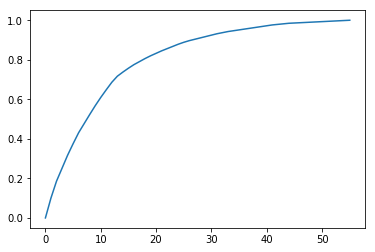

In [35]:
from collections import Counter
counter = Counter(pairs)
types = sorted(counter.items(), key=lambda x: x[1], reverse=True)
cumulate = [0]
for t,c in types:
    cumulate.append(c+cumulate[-1])
cumulate = [c/cumulate[-1] for c in cumulate]

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cumulate)
